# Score-driven Tensor Factor Model

In [1]:
# Potentially Download packages
!pip install autograd
!pip install pymanopt


# Imports
import numpy as np
import autograd.numpy as anp
from joblib import Parallel, delayed

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm, inv
from scipy.optimize import minimize

import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
from pymanopt.manifolds import Product, Euclidean, Stiefel, SymmetricPositiveDefinite
from pymanopt import Problem
from pymanopt.optimizers import SteepestDescent

# Define path
path = "/Users/joche/Documents/Github/Score-driven_Tensor_Factor_Model/"

np.set_printoptions(suppress=True, precision=4)

## Transformations

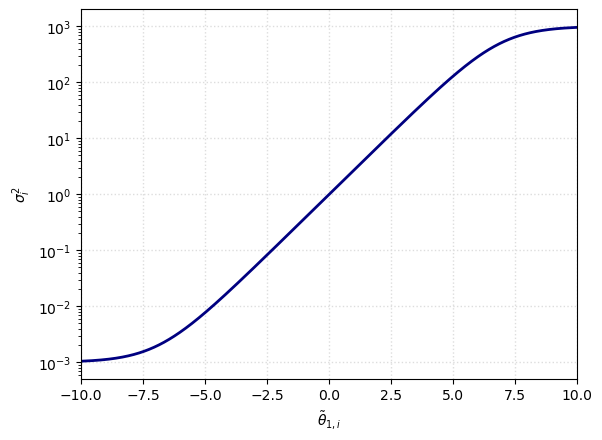

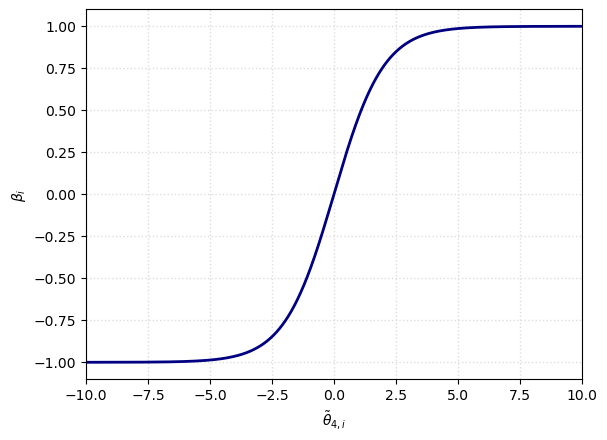

1.0
0.5


In [2]:
# Testing over X
XPlot = np.arange(-100,100,0.01)

# Define c_low and c_high
c_low = 0.001
c_high = 1000

# Compute values for every X
SigmaPlot = c_low+(c_high-c_low) / (1+np.exp(-XPlot)*((c_high-1) / (1-c_low)))
BPlot = 2 / (1+np.exp(-XPlot)) - 1

plt.plot(XPlot,SigmaPlot,c="navy",linewidth=2)
plt.xlabel(r"$\tilde{\theta}_{1,i}$")
plt.ylabel(r'$\sigma^2_i$')
plt.xlim(-10,10)
plt.yscale("log")
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()

plt.plot(XPlot,BPlot,c="navy",linewidth=2)
plt.xlabel(r"$\tilde{\theta}_{4,i}$")
plt.ylabel(r'$\beta_i$')
plt.xlim(-10,10)
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()

XTest = 0
print(c_low+(c_high-c_low) / (1+np.exp(-XTest)*((c_high-1) / (1-c_low))))
print(2 / (1+np.exp(-XTest)*1/3) - 1)

## Model

In [3]:
def sim_data():
    # Define matrix A and B
    A = np.diag(np.array([0.95 - 0.05 * k for k in range(r)]))
    B = np.diag(np.array([0.95 - 0.05 * k for k in range(r)]))

    # Define Sigma
    sigmas = np.random.uniform(0.5,1,d)
    Sigma = np.diag(sigmas)
    Sigma_inv = inv(Sigma)

    # Define, rotate, and fill each U_k
    U_k = []
    for k in range(K):
        U_pre = np.random.normal(size=(d_array[k], r_array[k]))

        # Rotate matrix
        U_k.append(U_pre @ sqrtm(inv(U_pre.T @ U_pre)))

    # Create empty Numpy objects to fill
    factors_true = np.zeros(np.append(T,r_array))
    data = np.zeros(np.append(T,d_array))

    # Define initial factor
    f_t = np.zeros((r,1))

    # Calculate the U term
    U_term = 1
    for k in range(K):
        U_term = np.kron(U_term,U_k[K-k-1])
        
    U_term = d**0.5 * Sigma**0.5 @ U_term

    # Compute the first data point
    X_t = U_term @ f_t + np.random.normal(np.zeros(d),sigmas**0.5,(1,d)).reshape(-1,1)

    # Compute all other error terms
    epsilon_t = np.random.normal(np.zeros(d),sigmas**0.5,(T,d))

    # Define the U term @ Sigma term to fill in the loop
    U_Sig = 1/d * A @ U_term.T @ Sigma_inv

    # Loop over all time
    for t in range(T):
        # Recursively compute the factors and data points
        f_t = U_Sig @ (X_t - U_term @ f_t) + B @ f_t
        X_t = U_term @ f_t + epsilon_t[t].reshape(-1,1)

        # Save the factors and data in the Numpy objects
        factors_true[t] = f_t.reshape(r_array)
        data[t] = X_t.reshape(d_array)

    return data, factors_true, U_term

In [9]:
def get_opt_theta(data):

    # Check the number of U_k's to choose the right algorithm 
    if (K == 1):
        # Define Manifold and its initial values
        manifold = Product([Euclidean(d), Stiefel(n=d_array[0], p=r_array[0]), Euclidean(r), Euclidean(r)])
        init = [np.zeros(d),np.vstack((np.eye(r_array[0]),np.zeros((d_array[0]-r_array[0],r_array[0])))),np.ones(r),np.ones(r)]

        # Define the objective function
        @pymanopt.function.autograd(manifold)
        def llfun(theta_1,theta_2_1,theta_3,theta_4):

            # Transform variables
            Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
            U_hat = d**0.5 * Sigma_hat**0.5 @ theta_2_1
            A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
            B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)

            # Define the initial log likelihood value
            llvalue = 0

            # Define initial factor
            f_t = anp.zeros((r,1))

            # Define the inverse of Sigma
            Sigma_inv = anp.linalg.inv(Sigma_hat)

            # Define the U term @ Sigma term to fill in the loop
            U_Sig = 1/d * A_hat @ anp.transpose(U_hat) @ Sigma_inv

            # Define initial X breve
            X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t

            # Loop over all time
            for t in range(1,T):
                # Recursively compute the factors, X breve, and log likelihood value
                f_t =  U_Sig @ X_breve + B_hat @ f_t
                X_breve = anp.reshape(data[t],(-1,1)) - U_hat @ f_t
                llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]

            return -(llvalue / (T-1) - 1/2 * anp.log(anp.linalg.det(Sigma_hat)) - d/2 * anp.log(2*anp.pi))

    elif (K == 2):
        # Define Manifold and its initial values
        manifold = Product([Euclidean(d), Stiefel(n=d_array[0], p=r_array[0]), Stiefel(n=d_array[1], p=r_array[1]), Euclidean(r), Euclidean(r)])
        init = [np.zeros(d),np.vstack((np.eye(r_array[0]),np.zeros((d_array[0]-r_array[0],r_array[0])))), np.vstack((np.eye(r_array[1]),np.zeros((d_array[1]-r_array[1],r_array[1])))),np.ones(r),np.ones(r)]

        # Define the objective function
        @pymanopt.function.autograd(manifold)
        def llfun(theta_1,theta_2_1,theta_2_2,theta_3,theta_4):

            # Transform variables
            Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
            U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_2_2,theta_2_1)
            A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
            B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)

            # Define the initial log likelihood value
            llvalue = 0

            # Define initial factor
            f_t = anp.zeros((r,1))

            # Define the inverse of Sigma
            Sigma_inv = anp.linalg.inv(Sigma_hat)

            # Define the U term @ Sigma term to fill in the loop
            U_Sig = 1/d * A_hat @ anp.transpose(U_hat) @ Sigma_inv

            # Define initial X breve
            X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t

            # Loop over all time
            for t in range(1,T):
                # Recursively compute the factors, X breve, and log likelihood value
                f_t =  U_Sig @ X_breve + B_hat @ f_t
                X_breve = anp.reshape(data[t],(-1,1)) - U_hat @ f_t
                llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]

            return -(llvalue / (T-1) - 1/2 * anp.log(anp.linalg.det(Sigma_hat)) - d/2 * anp.log(2*anp.pi))

    elif (K == 3):
        # Define Manifold and its initial values
        manifold = Product([Euclidean(d), Stiefel(n=d_array[0], p=r_array[0]), Stiefel(n=d_array[1], p=r_array[1]), Stiefel(n=d_array[2], p=r_array[2]),Euclidean(r), Euclidean(r)])
        init = [np.zeros(d),np.vstack((np.eye(r_array[0]),np.zeros((d_array[0]-r_array[0],r_array[0])))), np.vstack((np.eye(r_array[1]),np.zeros((d_array[1]-r_array[1],r_array[1])))), np.vstack((np.eye(r_array[2]),np.zeros((d_array[2]-r_array[2],r_array[2])))),np.ones(r),np.ones(r)]

        # Define the objective function
        @pymanopt.function.autograd(manifold)
        def llfun(theta_1,theta_2_1,theta_2_2,theta_2_3,theta_3,theta_4):

            # Transform variables
            Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
            U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_2_3,anp.kron(theta_2_2,theta_2_1))
            A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
            B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)

            # Define the initial log likelihood value
            llvalue = 0

            # Define initial factor
            f_t = anp.zeros((r,1))

            # Define the inverse of Sigma
            Sigma_inv = anp.linalg.inv(Sigma_hat)

            # Define the U term @ Sigma term to fill in the loop
            U_Sig = 1/d * A_hat @ anp.transpose(U_hat) @ Sigma_inv

            # Define initial X breve
            X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t

            # Loop over all time
            for t in range(1,T):
                # Recursively compute the factors, X breve, and log likelihood value
                f_t =  U_Sig @ X_breve + B_hat @ f_t
                X_breve = anp.reshape(data[t],(-1,1)) - U_hat @ f_t
                llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]

            return -(llvalue / (T-1) - 1/2 * anp.log(anp.linalg.det(Sigma_hat)) - d/2 * anp.log(2*anp.pi))

    else:
        print("Unsupported K")

    # Get optimized parameter with the Pymanopt package
    problem = Problem(manifold, llfun)
    # optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=20)
    optimizer = pymanopt.optimizers.ConjugateGradient(max_iterations=30,min_step_size=0.04)

    return optimizer.run(problem, initial_point=init).point

In [10]:
def calRMSE(theta_hat, data, factors_true, U_true):
    
    # Transform variables (depending on K)
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_hat[0])*((c_high-1) / (1-c_low))))
    if (K == 1):
        U_hat = d**0.5 * Sigma_hat**0.5 @ theta_hat[1]
    elif (K == 2):
        U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_hat[2],theta_hat[1])
    elif (K == 3):
        U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_hat[3],anp.kron(theta_hat[2],theta_hat[1]))
    A_hat = anp.diag(2 / (1+anp.exp(-theta_hat[K + 1])*1/3) - 1)
    B_hat = anp.diag(2 / (1+anp.exp(-theta_hat[K + 2])*1/3) - 1)

    # Define initial factor
    f_t = anp.zeros((r,1))
    
    # Create empty Numpy object to fill
    factors_opt = np.zeros(np.append(T,r_array))
    
    # Define the inverse of Sigma
    Sigma_inv = anp.linalg.inv(Sigma_hat)
    
    # Define the U term @ Sigma term to fill in the loop
    U_Sig = 1/d * anp.transpose(U_hat) @ Sigma_inv
    
    # Loop over all time
    for t in range(1,T):
        # Compute the factors
        f_t = A_hat @ U_Sig @ (anp.reshape(data[t-1],(-1,1)) - U_hat @ f_t) + B_hat @ f_t
        
        # Save the factors in the Numpy object
        factors_opt[t] = f_t.reshape(r_array)

    # Reshape factors and loadings
    factors_true = factors_true.reshape(T,r)
    factors_opt = factors_opt.reshape(T,r)
    U_true = U_true.reshape(d,r)
    U_hat = U_hat.reshape(d,r)
    
    RMSE_factors = np.zeros(r)
    RMSE_loadings = np.zeros(r)
    MAE_factors = np.zeros(r)
    MAE_loadings = np.zeros(r)
    
    # Loop over the number of the factors
    for i in range(r):
#         print("For r=",i,":")
        
        # Create array to fill correlation coefficients
        corr_coefs = np.zeros(r)
        
        # Loop over the number of the factors
        for j in range(r):
            # Fill the array with the absolute correlation coefficients between a true factor and all optimized ones
            corr_coefs[j] = np.abs(np.corrcoef(factors_opt[:,j],factors_true[:,i]))[0,1]

        # Get the true factor and its most correlated optimized one
        factor_true = factors_true[:,i]
        factor_opt = factors_opt[:,np.argmax(corr_coefs)]
        loading_true = U_true[:,i]
        loading_opt = U_hat[:,np.argmax(corr_coefs)]
        
        # Alternative way to match factors and loading
#         factor_true = factors_true[:,np.argsort(np.var(factors_true.T,(1)))[i]]
#         factor_opt = factors_opt[:,np.argsort(np.var(factors_opt.T,(1)))[i]]
#         loading_true = U_true[:,np.argsort(np.var(factors_true.T,(1)))[i]]
#         loading_opt = U_hat[:,np.argsort(np.var(factors_opt.T,(1)))[i]]
        
        # Normalize the factors and the loadings
#         factor_true = factor_true/np.std(factor_true)
#         factor_opt = factor_opt/np.std(factor_opt)
#         loading_true = loading_true/np.std(loading_true)
#         loading_opt = loading_opt/np.std(loading_opt)
        
        # Correct the sign if needed
        if (0 > np.corrcoef(factor_true,factor_opt)[0,1]):
            factor_opt = -factor_opt
            loading_opt = -loading_opt
            
        # Calculate performance measures
        RMSE_factors[i] = np.sqrt(sum((factor_opt-factor_true)**2)/T)
        RMSE_loadings[i] = np.sqrt(sum((loading_opt-loading_true)**2)/d)
        MAE_factors[i] = sum(np.abs(factor_opt-factor_true))/T
        MAE_loadings[i] = sum(np.abs(loading_opt-loading_true))/d
        
#         plt.plot(np.arange(T),factor_true,c="deepskyblue",linewidth=1)
#         plt.plot(np.arange(T),factor_opt,c="tomato",linewidth=1)
#         plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
#         plt.show()

    return RMSE_factors[0], np.mean(RMSE_factors), RMSE_loadings[0], np.mean(RMSE_loadings), MAE_factors[0], np.mean(MAE_factors), MAE_loadings[0], np.mean(MAE_loadings)

In [11]:
def sim_iteration():
    
    # Potentially add a seed
    # np.random.seed(1)

    # Simulate the data
    data, factors_true, U_true = sim_data()
    
    # Get the optimal parameters
    theta_hat = get_opt_theta(data)
    
    # Return the performance measures
    return calRMSE(theta_hat, data, factors_true, U_true)

In [12]:
def Monte_Carlo_sim(sim_amount):
    
    # Simulate and Store performance measure
    sim_results = Parallel(n_jobs=6)(delayed(sim_iteration)() for i in range(sim_amount))
    column_names = ["RMSE_factor_1","RMSE_factor_mean","RMSE_loading_1","RMSE_loading_mean","MAE_factor_1","MAE_factor_mean","MAE_loading_1","MAE_loading_mean"]
    df_results = pd.DataFrame(sim_results,columns=column_names)

    return df_results

In [13]:
# Parameters
T = 1000
d_array = np.array([5,5,5])
r_array = np.array([2,2,2])

d = np.prod(d_array)
r = np.prod(r_array)
K = len(d_array)

sim_amount = 1000

df_results = Monte_Carlo_sim(sim_amount)
df_results.to_excel(path+ "Simulation_Results_K="+str(K)+"_d1="+str(d_array[0])+".xlsx")